## Model
W tym pliku zajmujemy się przygotowaniem danych pod model i zbudowaniem modelu binarnej klasyfikacji siecią neuronową.\
Dane wyciągnięte zostały w pliku feature_extraction.

In [1]:
import pandas as pd

data = pd.read_csv("urls.csv")
data.drop(columns="URL", inplace=True)
data["Label"] = data["Label"].replace({'good': 1, 'bad': 0})
data = data.dropna()

/var/folders/7y/z4ckz2m16zvb_lc_v2ddsc000000gn/T/ipykernel_2470/3399237845.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Label"] = data["Label"].replace({'good': 1, 'bad': 0})


In [3]:
data.head()

,Label,length_url,scheme,length_hostname,nb_qm,nb_www,nb_dots,nb_eq,nb_slash,nb_hyperlinks,ratio_digits_url,ratio_digits_hostname,longest_words_raw,longest_words_path,tld_in_subdomain,prefix_suffix,shortest_word_host,phish_hints,safe_anchors
0,0,225,0,0,1,0,6,4,10,0,0.257778,0.0,35,35,0,1,0,1,0.0
1,0,81,0,0,0,1,5,2,4,0,0.012346,0.0,14,14,0,1,0,1,0.0
2,0,177,0,0,0,0,7,0,11,0,0.265537,0.0,40,40,0,1,0,1,0.0
3,0,60,0,0,0,1,6,0,2,0,0.000000,0.0,15,15,0,1,0,0,0.0
4,0,116,0,0,1,0,1,0,10,0,0.181034,0.0,23,15,0,1,0,1,0.0


In [4]:
good, bad = data.Label.value_counts()
data_good = data[data.Label == 1]
data_bad = data[data.Label == 0]
good, bad

(392924, 156414)

Widzimy dysproporcję w danych. Usuniemy teraz odpowiednią ilość danych z dobrym linkiem.

In [5]:
from sklearn.utils import resample

data_good = resample(
	data_good, 
	replace=False,
	n_samples=bad,
	random_state=42
)

data = pd.concat([data_good, data_bad])
data = resample(
	data,
	replace = False
)

In [6]:
print(data.Label.value_counts())
data.head()

Label
0    156414
1    156414
Name: count, dtype: int64


,Label,length_url,scheme,length_hostname,nb_qm,nb_www,nb_dots,nb_eq,nb_slash,nb_hyperlinks,ratio_digits_url,ratio_digits_hostname,longest_words_raw,longest_words_path,tld_in_subdomain,prefix_suffix,shortest_word_host,phish_hints,safe_anchors
513399,0,47,0,0,0,0,1,0,5,0,0.000000,0.0,10,10,0,1,0,0,0.0
236062,1,38,0,0,0,0,4,0,2,0,0.105263,0.0,8,8,0,1,0,0,0.0
4740,0,41,0,0,0,0,1,0,4,0,0.000000,0.0,11,11,0,1,0,0,0.0
99259,0,77,0,0,0,0,6,0,4,0,0.000000,0.0,20,20,0,1,0,1,0.0
122870,0,56,0,0,0,0,2,0,5,0,0.000000,0.0,14,14,0,1,0,0,0.0


Normalizujemy dane.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

for col in data.columns:
    data[col] = scaler.fit_transform(pd.DataFrame(data[col]))

Dzielimy dane na zbiór treningowy i testowy.

In [8]:
from sklearn.model_selection import train_test_split
from torch import tensor, double, manual_seed

X = data.drop(columns="Label")
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = tensor(X_train.values, dtype=double)
X_test = tensor(X_test.values, dtype=double)
y_train = tensor(y_train.values, dtype=double).unsqueeze(1)
y_test = tensor(y_test.values, dtype=double).unsqueeze(1)

dimX = X_train.shape[1]

Budujemy model sieci neuronowej.

In [9]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    hidden_layer_sizes=(dimX, 1),
    activation='logistic',
	learning_rate='adaptive',
    solver='adam',
    warm_start=True,
    random_state=42,
)

Tranujemy model.

In [10]:
model.fit(X_train, y_train)

/Users/stefannosek/Documents/github/public/nn-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/stefannosek/Documents/github/public/nn-project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(18, 1),
              learning_rate='adaptive', random_state=42, warm_start=True)

Wykres wartości funkcji straty:

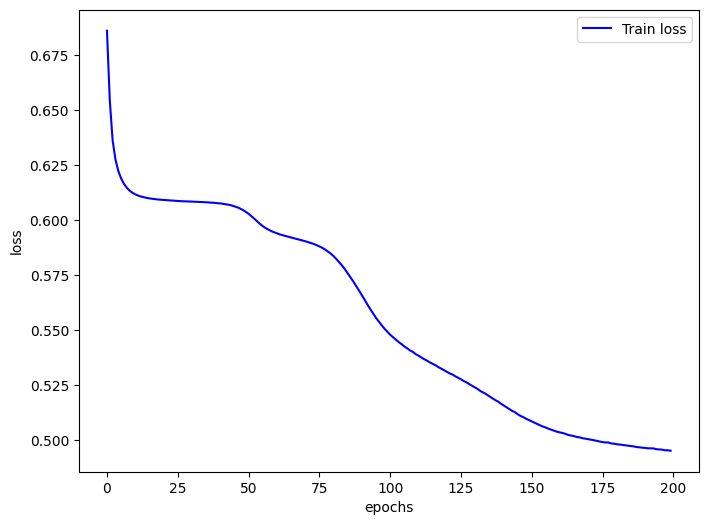

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=model.loss_curve_, label="Train loss", color="blue", ax=ax)

# Add a legend
ax.legend()

# Customize the plot (optional)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")

plt.show()

Report po klasyfikacji:

In [12]:
from sklearn.metrics import classification_report

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74     31361
         1.0       0.74      0.78      0.76     31205

    accuracy                           0.75     62566
   macro avg       0.75      0.75      0.75     62566
weighted avg       0.75      0.75      0.75     62566

